In [1]:
%cd ..

/scratch/gpfs/zzada/fconv


# testing notebook

In [19]:
from importlib import reload
# reload(sys.modules["util.atlas"])
# reload(sys.modules["util.plot"])

import os
import pickle
import torch
import numpy as np
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from scipy.stats import zscore, pearsonr
from collections import defaultdict
import seaborn as sns
from constants import *
from tqdm import tqdm
from util import subject
from util import plot
from util.path import Path
from util.atlas import Atlas
from himalaya.backend import set_backend

from himalaya.scoring import correlation_score
import sys

# resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1e9

In [3]:
modelname = "model-gpt2-medium_layer-0.75"

# confounds

In [34]:
dfc = pd.read_csv(
    "data/derivatives/fmriprep/sub-001/ses-1/func/sub-001_ses-1_task-Conv_run-1_desc-confounds_timeseries.tsv",
    sep="\t",
)
dfc

global_signal  global_signal_derivative1  \
0       627.307935                        NaN   
1       624.737483                  -2.570452   
2       624.008139                  -0.729344   
3       623.705264                  -0.302875   
4       624.831321                   1.126057   
..             ...                        ...   
539     595.343576                   1.908504   
540     596.031588                   0.688012   
541     596.701395                   0.669807   
542     596.321816                  -0.379579   
543     594.426792                  -1.895024   

     global_signal_derivative1_power2  global_signal_power2         csf  \
0                                 NaN         393515.245457  481.936383   
1                            6.607224         390296.922662  478.058828   
2                            0.531943         389386.157268  477.065866   
3                            0.091733         389008.256030  476.522812   
4                            1.268005         390414.179968  475.839324   
..                                ...                   ...         ...   
539                          3.642386         354433.973164  460.373519   
540                          0.473361         355253.653583  461.929946   
541                          0.448642         356052.554799  463.391648   
542                          0.144080         355599.708503  464.865998   
543                          3.591117         353343.211045  461.078281   

     csf_derivative1     csf_power2  csf_derivative1_power2  white_matter  \
0                NaN  232262.677415                     NaN    517.194972   
1          -3.877555  228540.242987               15.035434    516.754469   
2          -0.992962  227591.840162                0.985974    516.520381   
3          -0.543053  227073.990763                0.294907    516.132956   
4          -0.683488  226423.062575                0.467156    516.966243   
..               ...            ...                     ...           ...   
539         3.055788  211943.777413                9.337842    499.188587   
540         1.556427  213379.275190                2.422464    499.676327   
541         1.461701  214731.819125                2.136571    499.715087   
542         1.474351  216100.396409                2.173710    500.192620   
543        -3.787717  212593.181404               14.346801    500.091312   

     white_matter_derivative1  ...  motion_outlier71  motion_outlier72  \
0                         NaN  ...               0.0               0.0   
1                   -0.440503  ...               0.0               0.0   
2                   -0.234088  ...               0.0               0.0   
3                   -0.387425  ...               0.0               0.0   
4                    0.833287  ...               0.0               0.0   
..                        ...  ...               ...               ...   
539                  0.653042  ...               0.0               0.0   
540                  0.487740  ...               0.0               0.0   
541                  0.038760  ...               0.0               0.0   
542                  0.477533  ...               0.0               0.0   
543                 -0.101308  ...               0.0               0.0   

     motion_outlier73  motion_outlier74  motion_outlier75  motion_outlier76  \
0                 0.0               0.0               0.0               0.0   
1                 0.0               0.0               0.0               0.0   
2                 0.0               0.0               0.0               0.0   
3                 0.0               0.0               0.0               0.0   
4                 0.0               0.0               0.0               0.0   
..                ...               ...               ...               ...   
539               0.0               0.0               0.0               0.0   
540               0.0               0.0               0.0            

In [35]:
dfc[[c for c in dfc.columns if "derivative" in c]]

global_signal_derivative1  global_signal_derivative1_power2  \
0                          NaN                               NaN   
1                    -2.570452                          6.607224   
2                    -0.729344                          0.531943   
3                    -0.302875                          0.091733   
4                     1.126057                          1.268005   
..                         ...                               ...   
539                   1.908504                          3.642386   
540                   0.688012                          0.473361   
541                   0.669807                          0.448642   
542                  -0.379579                          0.144080   
543                  -1.895024                          3.591117   

     csf_derivative1  csf_derivative1_power2  white_matter_derivative1  \
0                NaN                     NaN                       NaN   
1          -3.877555               15.035434                 -0.440503   
2          -0.992962                0.985974                 -0.234088   
3          -0.543053                0.294907                 -0.387425   
4          -0.683488                0.467156                  0.833287   
..               ...                     ...                       ...   
539         3.055788                9.337842                  0.653042   
540         1.556427                2.422464                  0.487740   
541         1.461701                2.136571                  0.038760   
542         1.474351                2.173710                  0.477533   
543        -3.787717               14.346801                 -0.101308   

     white_matter_derivative1_power2  trans_x_derivative1  \
0                                NaN                  NaN   
1                           0.194043            -0.000658   
2                           0.054797            -0.000632   
3                           0.150098             0.007651   
4                           0.694367            -0.022792   
..                               ...                  ...   
539                         0.426464             0.007285   
540                         0.237891            -0.027113   
541                         0.001502            -0.015232   
542                         0.228038            -0.000577   
543                         0.010263            -0.001153   

     trans_x_derivative1_power2  trans_y_derivative1  \
0                           NaN                  NaN   
1                  4.332272e-07             0.016124   
2                  3.994240e-07            -0.043405   
3                  5.853933e-05             0.008397   
4                  5.194661e-04            -0.000046   
..                          ...                  ...   
539                5.306831e-05             0.005779   
540                7.351365e-04             0.060325   
541                2.320138e-04            -0.057304   
542                3.335062e-07             0.069671   
543                1.329640e-06            -0.136801   

     trans_y_derivative1_power2  trans_z_derivative1  \
0                           NaN                  NaN   
1                  2.599963e-04             0.039534   
2                  1.884029e-03             0.069097   
3                  7.050625e-05             0.024975   
4                  2.116000e-09            -0.011567   
..                          ...                  ...   
539                3.339684e-05            -0.099750   
540                3.639106e-03             0.081580   
541                3.283748e-03             0.132610   
542                4.854048e-03            -0.074900   
543                1.871449e-02             0.035760   

     trans_z_derivative1_power2  rot_x_derivative1  rot_x_derivative1_power2  \
0                           NaN                NaN                       NaN   
1                      0.001563           0.000823          

# fwdisp

In [ ]:
results = defaultdict(list)

for sub in tqdm(SUBS_STRANGERS):
    # correlation between BOLD and fwdisp
    data, fsdisp = subject.get_bold(
        sub, return_cofounds=["framewise_displacement"]
    )
    _, switches = subject.get_button_presses(sub)
    prod_maskB = switches.astype(bool)
    comp_maskB = np.logical_not(prod_maskB)

    results["prod_scores"].append(
        correlation_score(data[prod_maskB], fsdisp[prod_maskB])
    )
    results["comp_scores"].append(
        correlation_score(data[comp_maskB], fsdisp[comp_maskB])
    )
    results["prod_disp"].append(fsdisp[prod_maskB].mean())
    results["comp_disp"].append(fsdisp[comp_maskB].mean())

In [5]:
prod_disp = np.array(results["prod_disp"])
comp_disp = np.array(results["comp_disp"])
prod_scores = np.array(results["prod_scores"])
comp_scores = np.array(results["comp_scores"])

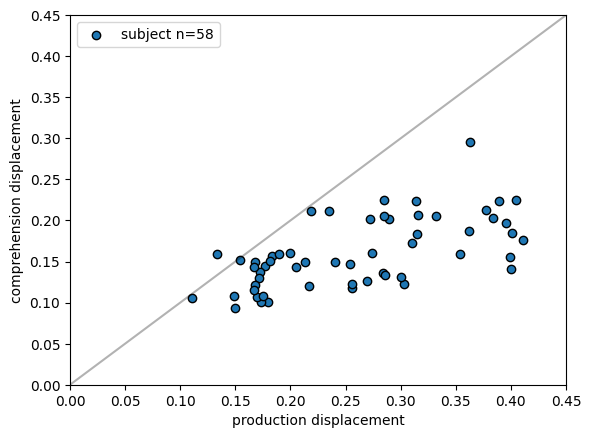

In [6]:
plt.scatter(
    prod_disp, comp_disp, label=f"subject n={len(prod_disp)}", edgecolors="black"
)
plt.axline(xy1=(0, 0), slope=1, alpha=0.3, color="k")
plt.xlim(0, 0.45)
plt.ylim(0, 0.45)
plt.xlabel("production displacement")
plt.ylabel("comprehension displacement")
plt.legend()
plt.show()

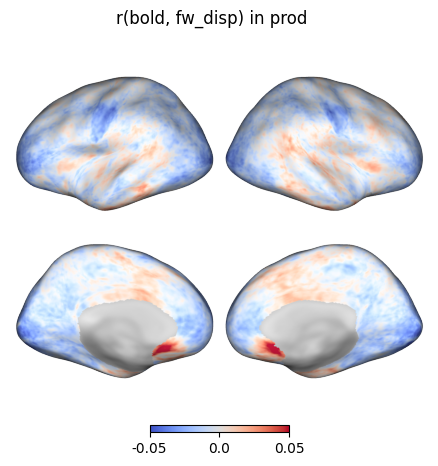

In [37]:
# how correlated are voxels to FWdisplacement during production?
values = np.mean(prod_scores, axis=0)
fig = plot.surface_plot(values, title="r(bold, fw_disp) in prod")

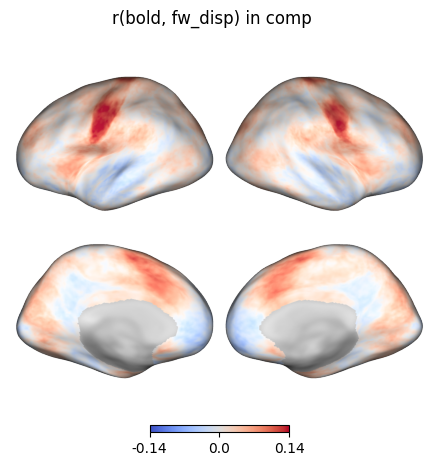

In [66]:
values = np.mean(comp_scores, axis=0)
fig = plot.surface_plot(values, title="r(bold, fw_disp) in comp")

## i knew you were black

In [65]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [66]:
subs = list(CONVS_STRANGERS) + [c - 100 for c in CONVS_STRANGERS]
# these subjects didn't do listen to this story, not sure why
subs.remove(11)
subs.remove(111)
subs.remove(12)

corrs, disps = [], []
for sub in tqdm(subs):
    boldpath = Path(
        root="data/derivatives/fmriprep/",
        datatype="func",
        sub="004",
        ses=1,
        task="Black",
        run=1,
        space="fsaverage6",
        hemi="L",
        suffix="bold",
        ext=".func.gii",
    )
    boldpath.update(sub=f"{sub:03d}")

    paths = [boldpath, boldpath.copy().update(hemi="R")]

    confpath = Path(
        root="data/derivatives/fmriprep/",
        sub="004",
        ses=1,
        datatype="func",
        task="Black",
        run=1,
        desc="confounds",
        suffix="timeseries",
        ext=".tsv",
    )
    confpath.update(sub=f"{sub:03d}")

    confdata = pd.read_csv(confpath, sep="\t", usecols=CONFOUNDS)
    confdata.bfill(inplace=True)

    masker = subject.GiftiMasker(
        t_r=TR,
        ensure_finite=True,
        standardize="zscore_sample",
        standardize_confounds=True,
    )
    data = masker.fit_transform(paths, confounds=confdata.to_numpy())
    fdisp = (
        pd.read_csv(confpath, sep="\t", usecols=["framewise_displacement"])
        .fillna(value=0)
        .to_numpy()
    )

    corrs.append(correlation_score(data, fdisp))
    disps.append(fdisp)

100%|██████████| 55/55 [05:40<00:00,  6.20s/it]


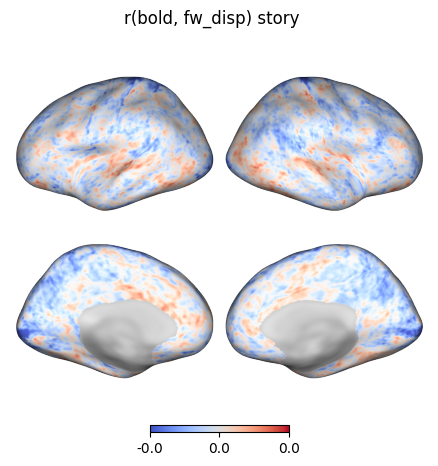

In [70]:
values = np.mean(corrs, axis=0)
fig = plot.surface_plot(values, title="r(bold, fw_disp) story", vmax=0.002)

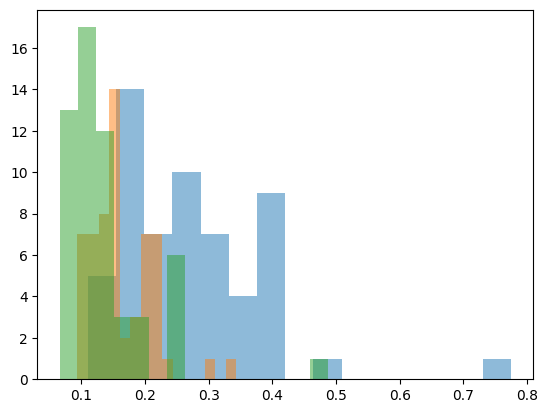

In [78]:
plt.hist(prod_disp, bins=15, alpha=0.5, label='prod');
plt.hist(comp_disp, bins=15, alpha=0.5, label='comp');
plt.hist(dd, bins=15, alpha=0.5, label='story');

/scratch/gpfs/zzada/conda-envs/fconv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/gpfs/zzada/conda-envs/fconv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

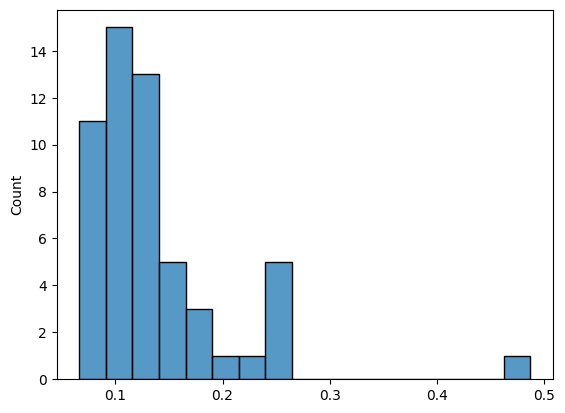

In [75]:
dd = np.stack(disps).mean((1, 2))
sns.histplot(dd)

# Encoding

In [3]:
# reload(sys.modules["util.subject"])
# reload(sys.modules["encoding"])
import encoding as enc

## regressors

In [4]:
sub = 105
X, features = enc.build_regressors(sub, modelname="model-gpt2-medium_layer-0.75")
X.shape, features

((1200, 2295),
 {'nuisance': slice(0, 8, None),
  'spectral': slice(8, 168, None),
  'phonemes': slice(168, 246, None),
  'production': slice(246, 1270, None),
  'comprehension': slice(1270, 2294, None)})

In [6]:
x_nuis = X[:, [0, 1, 2]]
x_in = X[:, 2:4].sum(axis=1, keepdims=True)
x_wr = X[:, 4:6].sum(axis=1, keepdims=True)
x_pr = X[:, 6:8].sum(axis=1, keepdims=True)
x_ph = X[:, 8:47] + X[:, 47:86]
x_lx = X[:, features["production"]] + X[:, features["comprehension"]]
Xnew = np.hstack((x_nuis, x_in, x_wr, x_pr, x_ph, x_lx))
features_new = dict(
    nuisance=slice(0, 6),
    phonemes=slice(6, 45),
    lexical=slice(45, 1069),
)

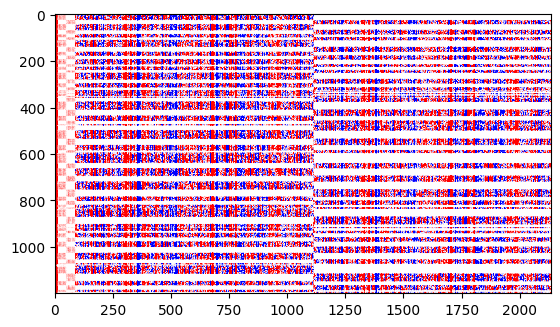

In [5]:
plt.imshow(X, vmin=-1, vmax=1, cmap="bwr")

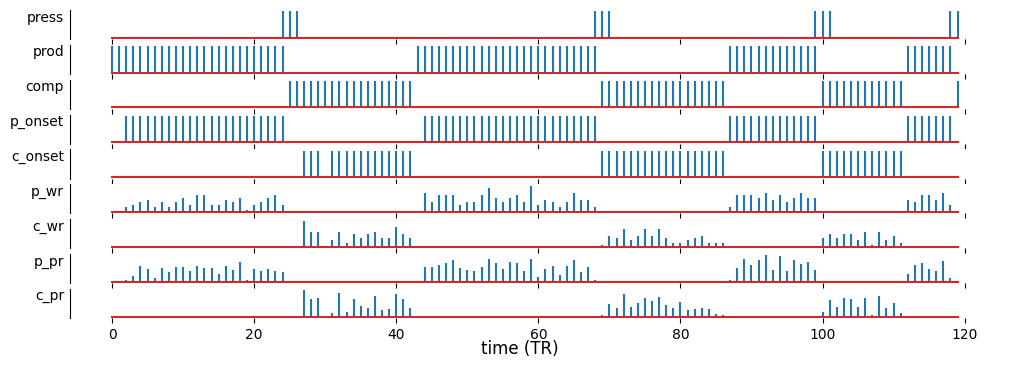

In [6]:
slc = slice(0, 120)
# slc = slice(960, 1200)
names = ["press", "prod", "comp", "p_onset", "c_onset", "p_wr", "c_wr", "p_pr", "c_pr"]
fig, axes = plt.subplots(len(names), 1, figsize=(12, 4), sharex=True)
for i, ax in enumerate(axes):
    ax.stem(X[slc, i], markerfmt="")
    # ax.plot(X[slc, i])
    ax.spines[["right", "top", "bottom"]].set_visible(False)
    ax.set_ylabel(names[i], rotation=0, horizontalalignment="right")
    ax.get_yaxis().set_ticks([])
    ax.spines[["right", "top", "bottom"]].set_visible(False)
fig.supxlabel("time (TR)")
fig.show()

In [58]:
data, conf = subject.get_bold(sub, return_cofounds=["framewise_displacement"])
data.shape

(1200, 81924)

In [3]:
def build_epochs(
    values: np.ndarray, onsets: np.ndarray, tmin: int = 5, tmax: int = 5
) -> np.ndarray:
    epochs = []
    for onset in onsets:
        start, end = onset - tmin, onset + tmax
        if start > 0 and end < values.size:
            epochs.append(values[start : end + 1])
    return np.stack(epochs).squeeze()

In [9]:
epochs = []
for sub in tqdm(SUBS_STRANGERS):
    X, _ = enc.build_regressors(sub, modelname="model-gpt2-medium_layer-0.75")
    _, conf = subject.get_bold(
        sub, return_cofounds=["framewise_displacement"], use_cache=True
    )
    # events, label = X[:, 0].nonzero()[0], 'button press'
    # events, label = (np.diff(X[:, 1]) > 0).nonzero()[0], 'comp -> prod'
    events, label = (np.diff(X[:, 1]) < 0).nonzero()[0], "prod -> comp"
    epochs.append(build_epochs(conf, events))
epochs = np.vstack(epochs)
epochs.shape

100%|██████████| 58/58 [02:49<00:00,  2.91s/it]


(1448, 10)

In [65]:
tmin, tmax = 5, 5
# events, label = X[:, 0].nonzero()[0], 'button press'
events, label = (np.diff(X[:, 1]) > 0).nonzero()[0], "comp -> prod"
# events, label = (np.diff(X[:, 1]) < 0).nonzero()[0], 'prod -> comp'
epochs = build_epochs(conf, events)
epochs.shape

(33, 10)

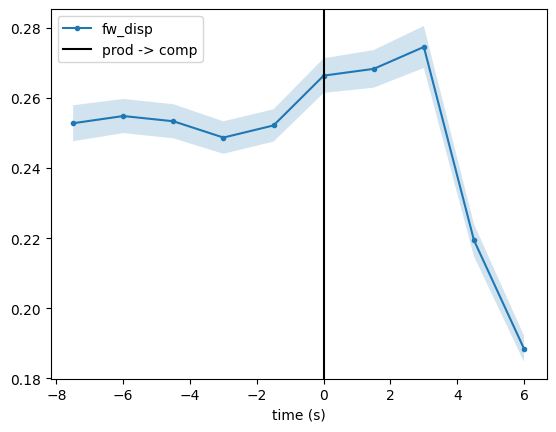

In [94]:
xaxis = np.arange(-tmin, tmax) * TR
mean = np.mean(epochs, 0).squeeze()
err = np.std(epochs, 0).squeeze() / np.sqrt(epochs.shape[0])
plt.plot(xaxis, mean, label="fw_disp", marker=".")
plt.fill_between(xaxis, mean - err, mean + err, alpha=0.2)
plt.axvline(0, c="k", label=label)
plt.xlabel("time (s)")
plt.legend(loc="best")
plt.show()

In [200]:
# prod_roi_mask.shape
data[c_mask][:, prod_roi_mask].shape

(541, 6619)

In [201]:
c_mask = X[:, 1] == 0
c_vox = correlation_score(data[c_mask][:, prod_roi_mask], conf[c_mask]).argmax()
c_vox

2857

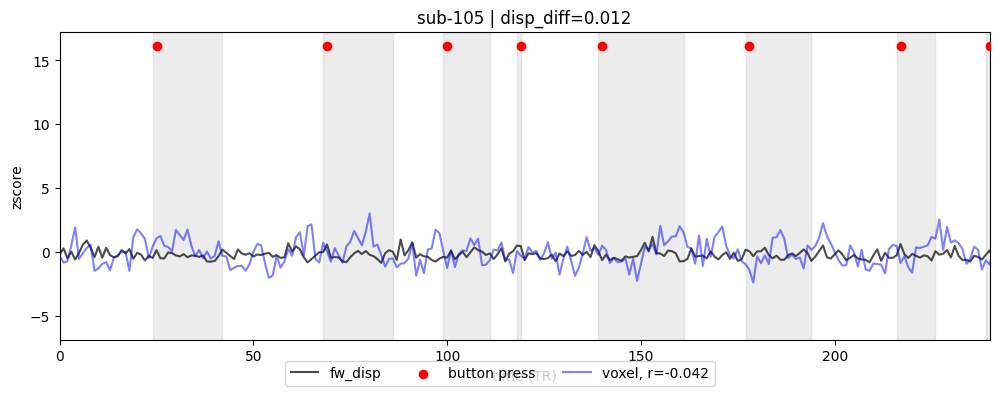

In [202]:
fig, ax = plt.subplots(figsize=(12, 4))

switches = [0] + np.nonzero(np.diff(X[:, 1]))[0].tolist()
for i in range(1, len(switches)):
    if i % 2 == 0:
        ax.axvspan(switches[i - 1], switches[i], color="gray", alpha=0.15, zorder=1)

ax.plot(zscore(conf), c="k", label="fw_disp", alpha=0.7, zorder=2)

presses = X[:, 0].nonzero()[0]
ax.scatter(
    presses,
    np.ones_like(presses) * ax.get_ylim()[1],
    c="red",
    label="button press",
    zorder=3,
)

r = pearsonr(data[:, c_vox], conf.squeeze()).statistic
ax.plot(
    zscore(data[:, c_vox]), c="blue", zorder=4, alpha=0.5, label=f"voxel, r={r:.3f}"
)
# ax.plot(zscore(data[:, p_vox]), c='green', zorder=4,  alpha=0.5)
ax.set_xlim(0, 240)
# ax.set_xlim(960, 1200)

compd = conf[X[:, 0] == 0].mean()
prodd = conf[X[:, 0] == 1].mean()
ax.set(
    ylabel="zscore",
    xlabel="time (TR)",
    title=f"sub-{sub:03d} | disp_diff={compd-prodd:.3f}",
)

fig.legend(loc="lower center", ncol=3, alignment="left")
fig.show()

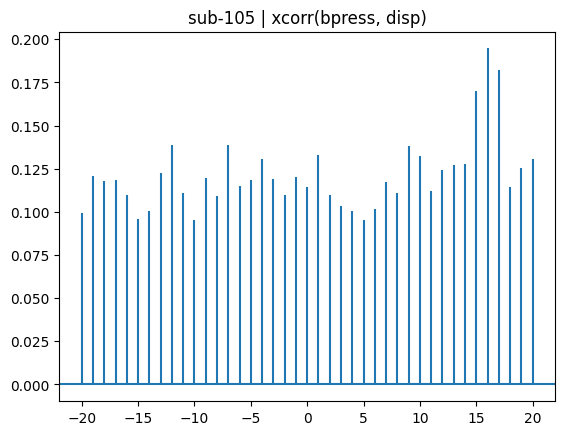

In [147]:
plt.title(f"sub-{sub:03d} | xcorr(bpress, disp)")
plt.xcorr(X[:, 0], conf.squeeze(), maxlags=20)
plt.show()

In [15]:
with open(
    f"encoding/sub-{sub:03d}/model-gpt2-medium_layer-0.75/sub-{sub:03d}.pkl", "rb"
) as f:
    ds = pickle.load(f)
ds.keys()

dict_keys(['cv_scores', 'cv_scores_prod', 'cv_scores_comp', 'cv_alphas', 'cv_preds', 'in_prod', 'in_comp', 'cv_models'])

In [16]:
preds = np.stack(ds["cv_preds"])
preds = np.swapaxes(preds, 0, 1).reshape(5, 1200, -1)
preds.shape

(5, 1200, 81924)

In [17]:
scores = np.stack(ds["cv_scores"]).mean(0)
print(scores.shape)
print(scores.max(-1))
print(scores.argmax(-1))

(5, 81924)
[0.34522906 0.2472285  0.13502821 0.3223776  0.36159092]
[ 5544 34602 38227 77042 66705]


In [21]:
voxid = 212
voxid = 66705

for score, feature in zip(scores[:, voxid].round(4), features):
    print(feature, score)

nuisance 0.0134
wp_rate 1e-04
phonemes 0.0023
production -0.0294
comprehension 0.3616


In [22]:
fnames = list(features.keys())
features

{'nuisance': slice(0, 4, None),
 'wp_rate': slice(4, 8, None),
 'phonemes': slice(8, 86, None),
 'production': slice(86, 1110, None),
 'comprehension': slice(1110, 2134, None)}

nuisance
wp_rate
phonemes
production
comprehension


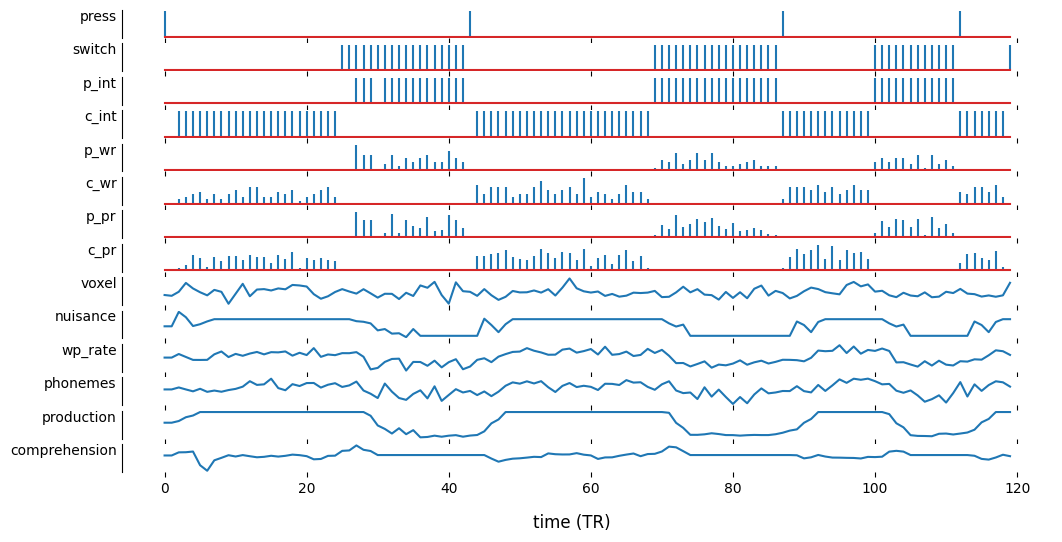

In [23]:
slc = slice(0, 120)

names = ["press", "switch", "p_int", "c_int", "p_wr", "c_wr", "p_pr", "c_pr"]
fig, axes = plt.subplots(14, 1, figsize=(12, 6), sharex=True)
for i, ax in enumerate(axes):
    ax.stem(X[slc, i], markerfmt="")
    ax.set_ylabel(names[i], rotation=0, horizontalalignment="right")
    if i == len(names) - 1:
        break

# plot actuals
i += 1
axes[i].plot(data[slc, voxid])
axes[i].set_ylabel("voxel", rotation=0, horizontalalignment="right")

# plot predictions
i += 1
for j in range(len(fnames)):
    axes[i + j].plot(preds[j, slc, voxid])
    axes[i + j].set_ylabel(fnames[j], rotation=0, horizontalalignment="right")

for ax in axes:
    ax.get_yaxis().set_ticks([])
    ax.spines[["right", "top", "bottom"]].set_visible(False)

fig.supxlabel("time (TR)")
fig.show()

In [24]:
print(pearsonr(data[:, voxid], conf[:, 0]))
for i in range(len(fnames)):
    print(fnames[i], pearsonr(preds[i, :, voxid], conf[:, 0]))

PearsonRResult(statistic=0.03832875652260853, pvalue=0.1845580089315461)
nuisance PearsonRResult(statistic=-0.04638223433142109, pvalue=0.10829202445347391)
wp_rate PearsonRResult(statistic=0.014819012680032294, pvalue=0.6080640687289771)
phonemes PearsonRResult(statistic=-0.022266446655133682, pvalue=0.4409298195192763)
production PearsonRResult(statistic=-0.026646696618731956, pvalue=0.3563875413131502)
comprehension PearsonRResult(statistic=-0.0317007889548526, pvalue=0.27251950706182226)


In [25]:
in_prod = ds["in_prod"]
in_comp = ds["in_comp"]

In [26]:
print("brain prod", pearsonr(data[in_prod, voxid], conf[in_prod, 0]).statistic)
print("brain comp", pearsonr(data[in_comp, voxid], conf[in_comp, 0]).statistic)
for i in range(len(fnames)):
    print(
        fnames[i],
        "prod",
        pearsonr(preds[i, in_prod, voxid], conf[in_prod, 0]).statistic,
    )
    print(
        fnames[i],
        "comp",
        pearsonr(preds[i, in_comp, voxid], conf[in_comp, 0]).statistic,
    )

brain prod -0.1519735479556865
brain comp 0.08151688241588999
nuisance prod -0.12887125740460856
nuisance comp -0.04405920408354318
wp_rate prod -0.1807661330389368
wp_rate comp 0.09121537042188309
phonemes prod -0.015994738573722325
phonemes comp 0.023811248454955965
production prod -0.16658235630362866
production comp -0.028097373687663466
comprehension prod -0.008090506558533715
comprehension comp -0.010644344053287184


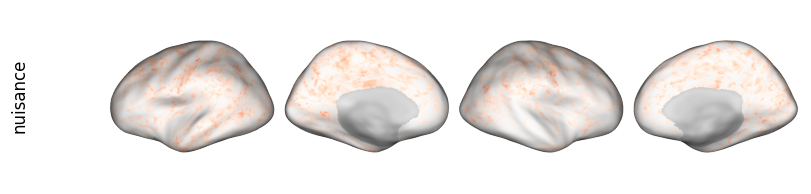

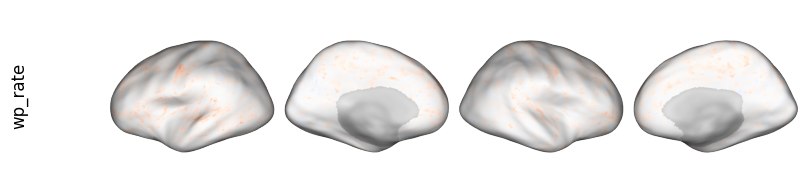

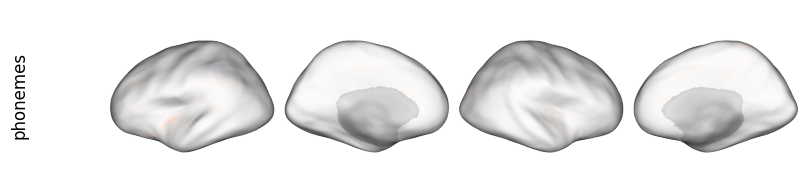

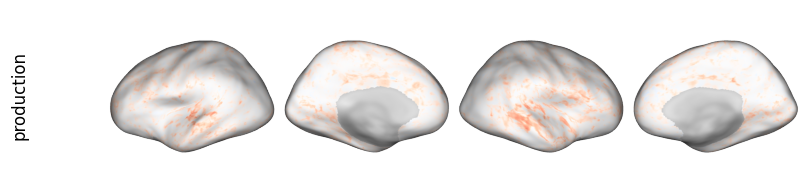

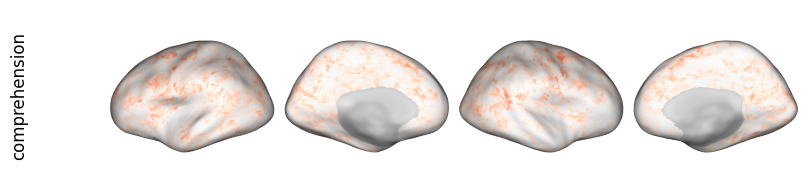

In [27]:
for i, feature in enumerate(fnames):
    values = scores[i]
    p = plot.get_surfplot(size=(800, 200), zoom=1.2, layout="row")
    p.add_layer(values, cmap="coolwarm", color_range=(-0.5, 0.5), cbar=False)
    fig = p.build()
    fig.supylabel(feature)
    fig.show()

## model

In [44]:
feature_names = list(features.keys())
slices = list(features.values())

In [47]:
pipeline = enc.build_model(feature_names, slices, np.linspace(0, 1, 10), 0, 1)
pipeline

Pipeline(steps=[('columnkernelizer',
                 ColumnKernelizer(n_jobs=1,
                                  transformers=[('nuissance',
                                                 Pipeline(steps=[('standardscaler',
                                                                  StandardScaler(with_std=False)),
                                                                 ('delayer',
                                                                  Delayer(delays=[2,
                                                                                  3,
                                                                                  4,
                                                                                  5])),
                                                                 ('kernelizer',
                                                                  Kernelizer())]),
                                                 slice(0, 3, None)),
                                                ('producton',
                                                 Pipeline(steps=[('standardscaler',
                                                                  StandardScaler(with_std=False)),
                                                                 ('delayer',
                                                                  Delayer(delays=[2,
                                                                                  3,...
                                                                  StandardScaler(with_std=False)),
                                                                 ('delayer',
                                                                  Delayer(delays=[2,
                                                                                  3,
                                                                                  4,
                                                                                  5])),
                                                                 ('kernelizer',
                                                                  Kernelizer())]),
                                                 slice(1027, 2051, None))])),
                ('caster', Caster()),
                ('multiplekernelridgecv',
                 MultipleKernelRidgeCV(kernels='precomputed',
                                       solver_params={'alphas': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                                                      'progress_bar': 0}))])

# ISC

In [3]:
from encoding import build_regressors, SplitDelayer
from sklearn.linear_model import LinearRegression
from nilearn.glm.first_level import glover_hrf
from scipy.ndimage import convolve1d

In [6]:
atlas = Atlas.schaefer2018()
atlas = Atlas.schaefer2018(rois=100)
# atlas = Atlas.glasser2016()
len(atlas)

100

In [28]:
lags = [1, 2, 3, 4]
delayer = SplitDelayer(delays=[2, 3, 4, 5])
scores = defaultdict(list)

hrf = glover_hrf(TR, oversampling=1, time_length=32)

for subA in tqdm(SUBS_STRANGERS[:28]):
    subB = subject.get_partner(subA)

    xA, features = build_regressors(subA, modelname)
    xB, features = build_regressors(subB, modelname)

    nuisA = xA[:, features["nuisance"]]
    nuisB = xB[:, features["nuisance"]]
    nuisA = convolve1d(nuisA, hrf, axis=0, mode="constant", origin=-(hrf.size // 2))
    nuisB = convolve1d(nuisB, hrf, axis=0, mode="constant", origin=-(hrf.size // 2))

    dataA = subject.get_bold(subA, use_cache=True)
    dataB = subject.get_bold(subB, use_cache=True)

    dataA = atlas.vox_to_parc(dataA)
    dataB = atlas.vox_to_parc(dataB)

    modelA = LinearRegression().fit(nuisA, dataA)
    modelB = LinearRegression().fit(nuisB, dataB)

    resA = dataA - modelA.predict(nuisA)
    resB = dataB - modelB.predict(nuisB)
    # resA, resB = dataA, dataB

    # prodmaskA = xA[:, 1].astype(bool)
    prodmaskA = delayer.fit_transform(xA[:, 1:2]).any(-1)

    for i in range(0, 1200, 240):
        runmask = slice(i, i + 240)

        residA = resA[runmask]
        residB = resB[runmask]
        brainA = dataA[runmask]
        brainB = dataB[runmask]

        scores[0].append(
            correlation_score(residA[prodmaskA[runmask]], residB[prodmaskA[runmask]])
        )
        scores[1].append(correlation_score(residA, residB))
        scores[2].append(
            correlation_score(brainA[prodmaskA[runmask]], brainB[prodmaskA[runmask]])
        )
        scores[3].append(correlation_score(brainA, brainB))

    # scores[1].append(correlation_score(resA[prodmaskA][:-1], resB[prodmaskA][1:]))
    # scores[-1].append(correlation_score(resA[prodmaskA][1:], resB[prodmaskA][:-1]))

100%|██████████| 28/28 [03:15<00:00,  7.00s/it]


In [35]:
lag = 1
values = np.mean(scores[lag], axis=0)
voxes = values
voxes = atlas.parc_to_vox(values)
voxes.max(), voxes.shape

(0.09720854380447713, (81924,))

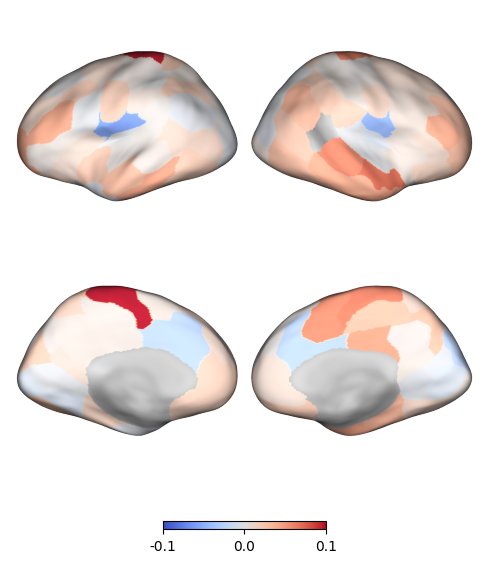

In [36]:
values = voxes
p = plot.get_surfplot(size=(600, 600), zoom=1.2)
p.add_layer(values, cmap="coolwarm", color_range=(-0.1, 0.1))
fig = p.build()
fig.show()

In [39]:
r = 125  # A5
r = 24  # A1
r = 9  # B3
mask = pmask == r
amax = np.argmax(scores[0][0] * mask)
amax, scores[0][0][amax]

(44975, 0.19197809336933677)

# intersubject MBC

In [3]:
from himalaya.scoring import correlation_score, correlation_score_split
from sklearn.model_selection import PredefinedSplit

In [18]:
scores = defaultdict(list)

hrf = glover_hrf(TR, oversampling=1, time_length=32)

# use subA's predictions on subB's actual neural data
for subA in tqdm(SUBS_STRANGERS[:28]):
    # load subA preds
    encpath = Path(root="encoding", sub=f"{subA:03d}", datatype=modelname, ext=".pkl")
    with open(encpath, "rb") as f:
        ds = pickle.load(f)
        Y_predsA = ds["cv_preds"]
        predsA = np.stack([m[-2] for m in Y_predsA]).reshape(
            1200, -1
        )  # take prod predictions

    # load subB
    subB = subject.get_partner(subA)
    xB, features = build_regressors(subB, modelname)
    nuisB = xB[:, features["nuisance"]]
    nuisB = convolve1d(nuisB, hrf, axis=0, mode="constant", origin=-(hrf.size // 2))
    dataB = subject.get_bold(subB, use_cache=True)
    modelB = LinearRegression().fit(nuisB, dataB)
    resB = dataB - modelB.predict(nuisB)
    prodmaskA = delayer.fit_transform(xB[:, 2:3]).any(-1)

    # scores[0].append(correlation_score(predsA[prodmaskA], resB[prodmaskA]))
    scores[1].append(correlation_score(predsA[prodmaskA][:-1], resB[prodmaskA][1:]))

100%|██████████| 28/28 [06:24<00:00, 13.75s/it]


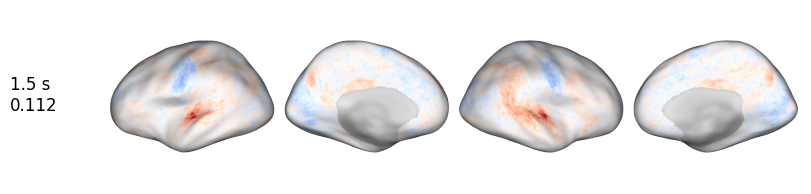

In [19]:
for lag in scores.keys():
    values = np.mean(scores[lag], axis=0)
    p = plot.get_surfplot(layout="row", size=(800, 200), zoom=1.2)
    p.add_layer(values, cmap="coolwarm", cbar=False, color_range=(-0.1, 0.1))
    fig = p.build()
    fig.supylabel(f"{lag * TR} s\n{values.max():.3f}", rotation=0)
    fig.show()

In [11]:
np.stack([m[-2] for m in Y_predsA]).reshape(1200, -1).shape

(1200, 81924)

In [10]:
# scores = []
scores_prod = []
scores_comp = []

run_ids = np.repeat(RUNS, CONV_TRS * 2)
kfold = PredefinedSplit(run_ids)

for subA in tqdm(SUBS_STRANGERS):
    subB = subject.get_partner(subA)
    dataA = subject.get_bold(subA, use_cache=True)

    # load encoding model
    encpath = Path(root="encoding", sub=f"{subB:03d}", datatype=modelname, ext=".pkl")
    with open(encpath, "rb") as f:
        ds = pickle.load(f)
        del ds["cv_models"]

    for k, (_, test_index) in enumerate(kfold.split()):
        Y_testA = dataA[test_index]
        Y_predsB = ds["cv_preds"][k]

        prod_maskB = ds["in_prod"][test_index]
        comp_maskB = ds["in_comp"][test_index]

        scores_prod.append(
            correlation_score(Y_testA[prod_maskB], Y_predsB[-2, prod_maskB])
        )
        scores_comp.append(
            correlation_score(Y_testA[comp_maskB], Y_predsB[-1, comp_maskB])
        )
        # scores.append(correlation_score_split(Y_test, Y_preds))

# scores = np.stack(scores).mean(0)
scores_prod = np.stack(scores_prod).mean(0)
scores_comp = np.stack(scores_comp).mean(0)
scores_prod.min(), scores_prod.max(), scores_comp.min(), scores_comp.max()

100%|██████████| 58/58 [03:30<00:00,  3.63s/it]


(-0.13946858, 0.13181408, -0.08461595, 0.12072577)

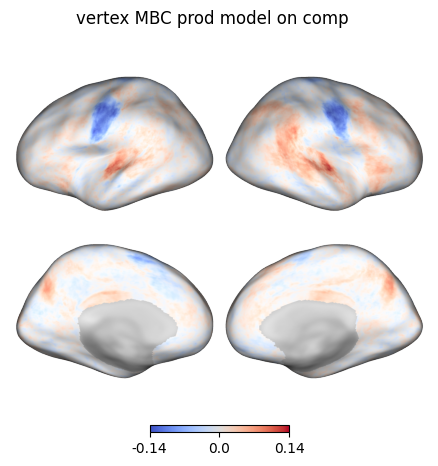

In [13]:
mx = 0.14
p = plot.get_surfplot()
p.add_layer(scores_prod, cmap="coolwarm", color_range=(-mx, mx))
# p.add_layer(scores_prod, cmap='magma', color_range=(0, mx))
fig = p.build()
fig.suptitle("vertex MBC prod model on comp")
fig.show()

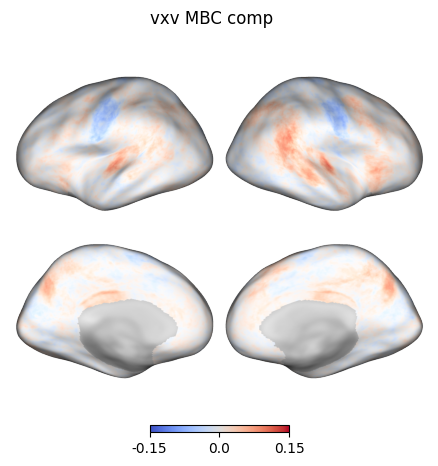

In [29]:
p = plot.get_surfplot()
p.add_layer(scores_comp, cmap="coolwarm", color_range=(-0.15, 0.15))
# p.add_layer(np.abs(scores_comp), cmap="magma", color_range=(-0, 0.15))
fig = p.build()
fig.suptitle("vxv MBC comp")
fig.show()

# Parcellation

In [5]:
region_numbers = [51]  # , 53, 9, 8, 54, 56, 78]
for i in region_numbers:
    print(id2label[i])
regions = np.where(np.isin(parc_mask, region_numbers), parc_mask, 0)
regions.shape, regions.sum()

L_1_ROI


((81924,), 53295)

In [191]:
prod_roi_mask = regions != 0

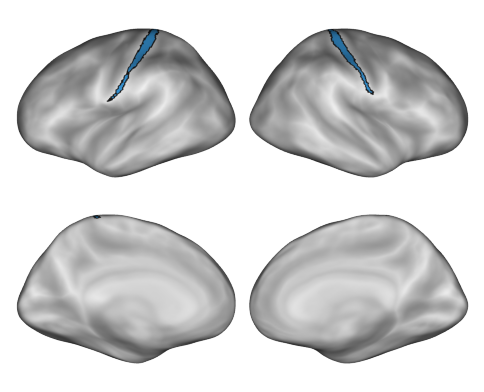

In [6]:
p = plot.get_surfplot()
p.add_layer(regions, cmap="tab10", cbar=False)
p.add_layer(regions, cmap="gray", as_outline=True, cbar=False)
fig = p.build()

In [17]:
del id2label[0]

In [18]:
label2id = {l.lstrip("L_").rstrip("_ROI"): i for i, l in id2label.items()}

In [19]:
rois = ["1", "3a", "3b", "4", "6d", "6v", "6r"]
for roi in rois:
    print(roi, label2id[roi])

1 51
3a 53
3b 9
4 8
6d 54
6v 56
6r 78


In [20]:
!mkdir -p figures/glasser-rois

In [21]:
for label, i in label2id.items():
    regions = parc_mask == i
    p = plot.get_surfplot(size=(800, 200), zoom=1.2, layout="row")
    p.add_layer(regions, cmap="tab10", cbar=False)
    p.add_layer(regions, cmap="gray", as_outline=True, cbar=False)
    fig = p.build()
    fig.supylabel(f"{i}:{label}", rotation=0)
    fig.savefig(f"figures/glasser-rois/{label}-{i:03d}.png")
    plt.close()
plt.close()

# 'story' encoding

In [2]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
subs = list(CONVS_STRANGERS) + [c - 100 for c in CONVS_STRANGERS]
# these subjects didn't do listen to this story, not sure why
subs.remove(11)
subs.remove(111)
subs.remove(12)

In [4]:
import torch
from sklearn.preprocessing import StandardScaler
from voxelwise_tutorials.delayer import Delayer
from sklearn.model_selection import KFold
from himalaya.kernel_ridge import KernelRidgeCV
from sklearn.pipeline import make_pipeline
from himalaya.scoring import correlation_score
from himalaya.backend import set_backend

In [5]:
# Function to average embeddings per TR
def construct_predictors(transcript_df, n_features, stim_dur, tr=1.5):
    # Find total number of TRs
    stim_trs = np.ceil(stim_dur / tr)

    # Add column to transcript with TR indices
    transcript_df["TR"] = transcript_df.onset.divide(tr).apply(np.floor).apply(int)

    # Compile the words within each TR
    words_per_tr = transcript_df.groupby("TR")["word"].apply(list)

    # Average the embeddings within each TR
    embeddings_per_tr = transcript_df.groupby("TR")["embedding"].mean()

    # Loop through TRs
    words_trs = []
    embeddings_trs = []
    for t in np.arange(stim_trs):
        if t in words_per_tr:
            words_trs.append(words_per_tr[t])

            # Fill in empty TRs with zero vectors
            if embeddings_per_tr[t] is not np.nan:
                embeddings_trs.append(embeddings_per_tr[t])
            else:
                embeddings_trs.append(np.zeros(n_features))
        else:
            words_trs.append([])
            embeddings_trs.append(np.zeros(n_features))

    embeddings = np.vstack(embeddings_trs)
    return embeddings

In [8]:
# Reload transcript with embeddings if already generated
transcript_f = "black_gpt2.pkl"
with open(transcript_f, "rb") as f:
    transcript_gpt2 = pickle.load(f)

In [9]:
# GPT-2 embeddings are 768-dimensional
X = construct_predictors(transcript_gpt2, 768, 800, tr=1.5)
X.shape

(534, 768)

In [10]:
# Split-half outer and inner cross-validation
outer_cv = KFold(n_splits=2)
inner_cv = KFold(n_splits=5)

# Mean-center each feature (columns of predictor matrix)
scaler = StandardScaler(with_mean=True, with_std=True)

# Create delays at 3, 4.5, 6, 7.5 seconds (1.5 s TR)
delayer = Delayer(delays=[2, 3, 4, 5])

# Ridge regression with alpha grid and nested CV
alphas = np.logspace(1, 10, 10)
ridge = KernelRidgeCV(alphas=alphas, cv=inner_cv)

# Chain transfroms and estimator into pipeline
pipeline = make_pipeline(scaler, delayer, ridge)

In [11]:
set_backend("torch")

<module 'himalaya.backend.torch' from '/scratch/gpfs/zzada/conda-envs/fconv/lib/python3.11/site-packages/himalaya/backend/torch.py'>

In [12]:
start_trs = 8
end_trs = 8
results = []

for sub in tqdm(subs):
    boldpath = Path(
        root="data/derivatives/fmriprep/",
        datatype="func",
        sub="004",
        ses=1,
        task="Black",
        run=1,
        space="fsaverage6",
        hemi="L",
        suffix="bold",
        ext=".func.gii",
    )
    boldpath.update(sub=f"{sub:03d}")
    paths = [boldpath, boldpath.copy().update(hemi="R")]

    confpath = Path(
        root="data/derivatives/fmriprep/",
        sub="004",
        ses=1,
        datatype="func",
        task="Black",
        run=1,
        desc="confounds",
        suffix="timeseries",
        ext=".tsv",
    )
    confpath.update(sub=f"{sub:03d}")

    confdata = pd.read_csv(confpath, sep="\t", usecols=CONFOUNDS)
    confdata.bfill(inplace=True)

    masker = subject.GiftiMasker(
        t_r=TR,
        ensure_finite=True,
        standardize="zscore_sample",
        standardize_confounds=True,
    )
    Y_bold = masker.fit_transform(paths, confounds=confdata.to_numpy())
    Y_bold = Y_bold[start_trs:-end_trs]

    # Loop through outer folds and estimate model
    Y_predicted = []
    for train, test in outer_cv.split(Y_bold):
        # Fit pipeline with transforms and ridge estimator
        pipeline.fit(X[train], Y_bold[train])

        # Compute predicted response
        predicted = pipeline.predict(X[test])
        Y_predicted.append(predicted)

    # Restack first and second half predictions
    Y_predicted = torch.vstack(Y_predicted)
    score_parcels = correlation_score(Y_bold, Y_predicted).numpy(force=True)

    results.append({"scores": score_parcels})

100%|██████████| 55/55 [15:06<00:00, 16.48s/it]


In [13]:
story_scores = np.vstack([r["scores"] for r in results])
# np.savez('storyscores.npz', story_scores)
story_scores.shape

(55, 81924)

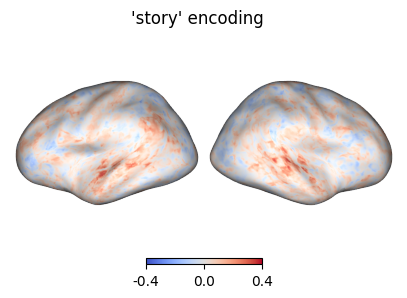

In [31]:
p = plot.get_surfplot(views="lateral", size=(400, 200), zoom=1.2)
p.add_layer(results[6]["scores"], cmap="coolwarm", color_range=(-0.4, 0.4))
fig = p.build()
fig.suptitle("'story' encoding")
fig.show()

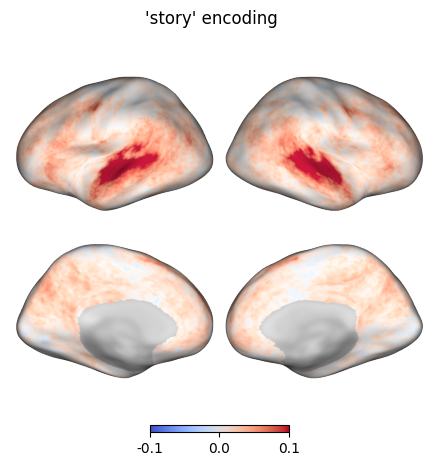

In [16]:
values = np.mean(story_scores, axis=0)
# values = black_scores[0]
# mx = max(np.abs(values.min()), values.max())

p = plot.get_surfplot()
p.add_layer(values, cmap="coolwarm", color_range=(-0.1, 0.1))
fig = p.build()
fig.suptitle("'story' encoding")
fig.show()

In [28]:
from util.atlas import get_glasser, parcellate_voxels

parc_mask, id2label = get_glasser()

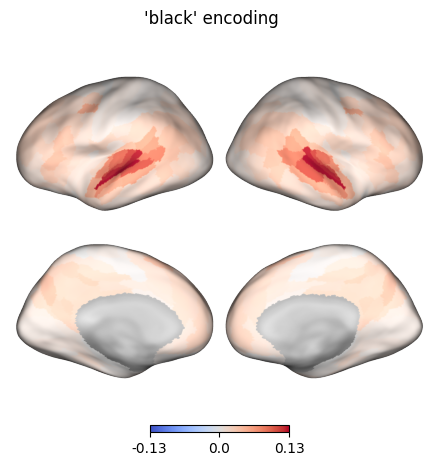

In [40]:
parcel_values = parcellate_voxels(values, parc_mask)
mx = max(np.abs(parcel_values.min()), parcel_values.max())

p = plot.get_surfplot()
p.add_layer(parcel_values, cmap="coolwarm", color_range=(-mx, mx))
fig = p.build()
fig.suptitle("'story' encoding")
fig.show()

# pycortex

In [82]:
import cortex
from neuromaps.transforms import fsaverage_to_fsaverage

# cortex.utils.download_subject(subject_id='fsaverage')
# cortex.utils.download_subject(subject_id='fsaverage', download_again=True)

/scratch/gpfs/zzada/conda-envs/fconv/lib/python3.11/site-packages/cortex/utils.py:1023: UserWarning: fsaverage is already present in the database. Set download_again to True if you wish to download the subject again.
  warnings.warn(


In [71]:
values = np.vstack(scores[0]).mean(0).astype(np.float32)
values.shape

(81924,)

In [74]:
dataL = values[:40962]
dataR = values[:40962]
gifL = nib.GiftiImage(darrays=(nib.gifti.gifti.GiftiDataArray(dataL),))
gifR = nib.GiftiImage(darrays=(nib.gifti.gifti.GiftiDataArray(dataR),))
gifLn, gifRn = fsaverage_to_fsaverage((gifL, gifR), "164k", hemi=("L", "R"))
resampled_data = np.concatenate((gifLn.agg_data(), gifRn.agg_data()))

In [88]:
# num_verts = 327684
# test_data = np.random.randn(num_verts)

shape = cortex.db.get_xfm("fsaverage", "identity").shape
data = np.arange(np.product(shape)).reshape(shape)

volume = cortex.Volume(
    data, subject="fsaverage", xfmname="identity", vmin=-0.1, vmax=0.1
)

In [89]:
vertex_data = cortex.Vertex(resampled_data, "fsaverage", vmin=-0.1, vmax=0.1)

Setting _INKSCAPE_GC=disable as a workaround for broken libgc
Unable to init server: Could not connect: Connection refused
(ld-linux-x86-64.so.2:1869752): glibmm-WARNING **: 11:59:27.706: Failed to wrap object of type 'GtkRecentManager'. Hint: this error is commonly caused by failing to call a library init() function.


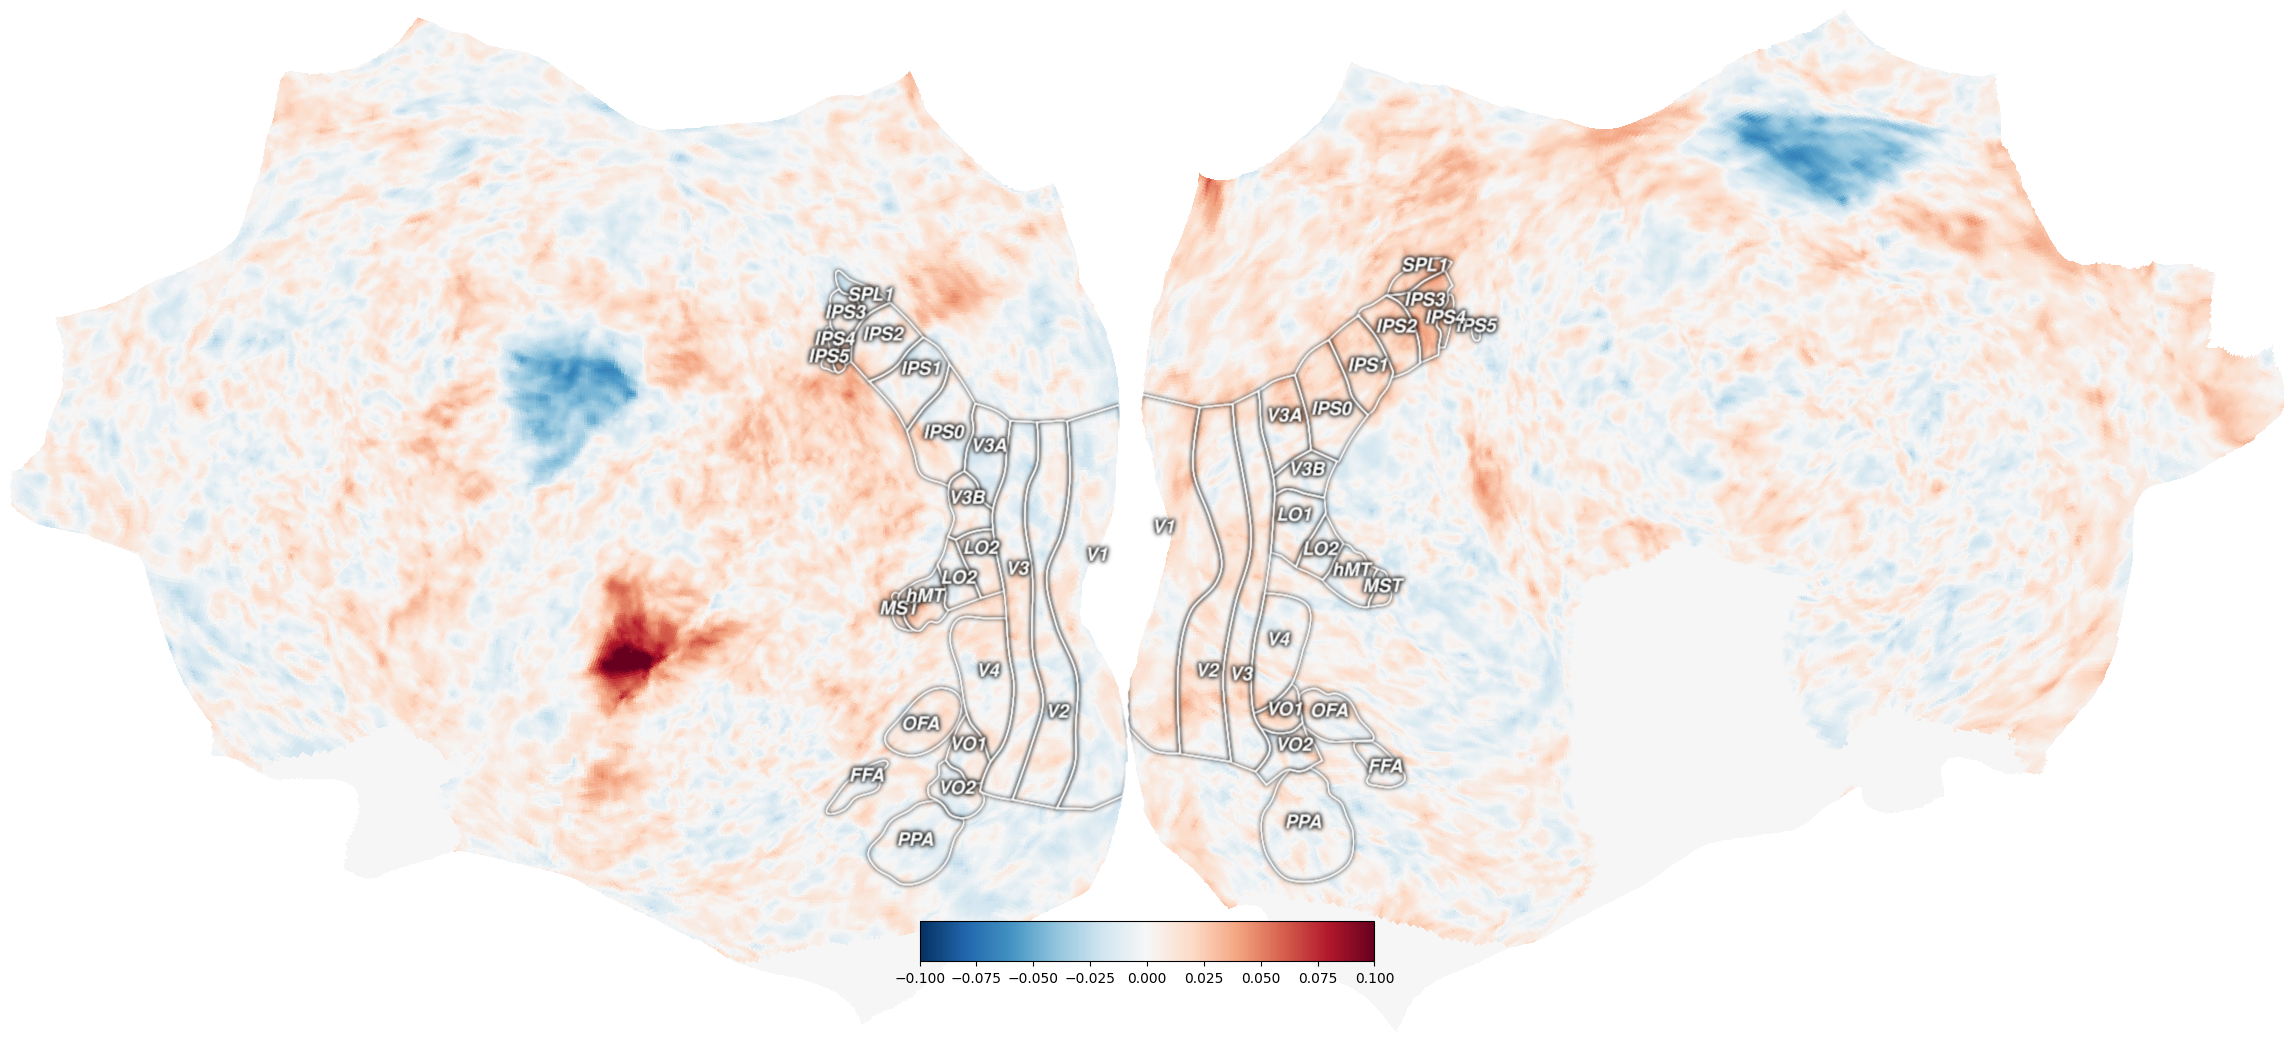

In [90]:
# And now we can display it on a flatmap
cortex.quickshow(vertex_data, wiith_labels=True, with_rois=True)
plt.show()

In [ ]:
# glasser_atlas = upsample_fsaverage(pmask, method='nearest')
# gifL, gifR = mni152_to_fsaverage('mats/allParcels_language_SN220.nii')
# lang_atlas = np.concatenate((gifL.agg_data(), gifR.agg_data()))
# lang_atlas = upsample_fsaverage(lang_atlas, method='nearest')
# lang_atlas.shape
# roi_vertices = cortex.Vertex(lang_atlas, 'fsaverage')
# cortex.quickshow(roi_vertices)
# plt.show()

In [ ]:
# lang atlas
llabels = [
    "LH_IFGorb",
    "LH_IFG",
    "LH_MFG",
    "LH_AntTemp",
    "LH_PostTemp",
    "RH_IFGorb",
    "RH_IFG",
    "RH_MFG",
    "RH_AntTemp",
    "RH_PostTemp",
    "eh",
    "eh2",
]
for i, label in enumerate(llabels, 1):
    verts = np.where(lang_atlas == i, lang_atlas, 0)
    roi_vertices = cortex.Vertex(verts, "fsaverage")
    print(i, label)
    cortex.add_roi(roi_vertices, name=label)

In [ ]:
# glasser atlas
rois = [
    # motor
    ("3", ("3a", "3b")),
    "4",
    ("6", ("6a", "6ma")),
    ("7", ("7m", "7Pm")),
    "8BM",
    ("31", ("31a", "31pd", "31pv")),
    # ifg
    "44",
    "45",
    ("47", ("47l", "47m", "47s")),
    "52",
    "55b",
    "PSL",
    "RSC",
    "SCEF",
    "SFL",
    "A4",
    "A5",
    "a24pr",
    "AVI",
    "PCV",
    "PEF",
    "PFm",
    "PGi",
    ("PoI", ("PoI1", "PoI2")),
    "FEF",
    "FOP5",
    ("ifj", ("IFJa", "IFJp")),
    ("ip", ("IP0", "IP1", "IP2")),
    ("sts", ("STSda", "STSdp", "STSva", "STSvp")),
    "STV",
    "RI",
    "A1",
    "LBelt",
    "PBelt",
    ("tpoj", ("TPOJ1", "TPOJ2", "TPOJ3")),
    ("POS2")
    # 8C? 46? a32pr? d32? LIPd? OP4?
]


for label in rois:
    if isinstance(label, str):
        verts = np.where(glasser_atlas == label2id[label], glasser_atlas, 0)
    else:
        label, labels = label
        roi_ids = np.array([label2id[roi] for roi in labels])
        verts = np.where(np.in1d(glasser_atlas, roi_ids), glasser_atlas, 0)
    roi_vertices = cortex.Vertex(verts, "fsaverage")
    print(label)
    cortex.add_roi(roi_vertices, name=f"G-{label}")

In [ ]:
# !cp /scratch/gpfs/zzada/conda-envs/fconv/share/pycortex/db/fsaverage/overlays.svg fsaverage-overlays-langloc.svg
!cp fsaverage-overlays-langloc.svg /scratch/gpfs/zzada/conda-envs/fconv/share/pycortex/db/fsaverage/overlays.svg
# cp /scratch/gpfs/zzada/conda-envs/fconv/share/pycortex/db/fsaverage/overlays.svg mats/fsaverage-overlays-backup.svg
!cp overlays.svg /scratch/gpfs/zzada/conda-envs/fconv/share/pycortex/db/fsaverage/overlays.svg

In [ ]:
# save flatmap for each ROI
!mkdir -p figures/flatmaps/glasser

# roi_ids = np.array([label2id[roi] for roi in rois])
# 'FOP1', 'FOP2', 'FOP3', 'FOP4', 'FOP5'
for label, id in label2id.items():
    verts = np.where(glasser_atlas == id, glasser_atlas, 0)
    roi_vertices = cortex.Vertex(verts, 'fsaverage')
    fn = f'figures/flatmaps/glasser/{label}-{id:03d}.png'
    cortex.quickflat.make_png(fn, roi_vertices, height=960)

# test delayer

In [ ]:
# test delayer delays reshape
from voxelwise_tutorials.delayer import Delayer

a = np.arange(10).reshape(-1, 2)
a
b = Delayer(delays=[0, 1, 2]).fit_transform(a)
b
b.reshape(5, 3, 2).mean(1)
torch.tensor(b, dtype=float).reshape(5, 3, 2).mean(1)
c = np.stack(np.split(b, 3, axis=1))
print(c.shape)
c.mean(0)